Clothing_Categorization

Parker Williamson
1/22/2018

This program takes a set of training data and classification data and using different methods of computer vision categorizes the test set based on the training set. The data that was used to analyze different techniques was clothing data from https://www.kaggle.com/zalando-research/fashionmnist.

(used https://pythonprogramming.net/convolutional-neural-network-cnn-machine-learning-tutorial/ as a template for CNN)

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import tensorflow as tf
from numpy import genfromtxt
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from scipy import stats

In [99]:
%matplotlib inline

Dictionary definitions shows the true categories that the dataset lists

In [100]:
definitions = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle boot'}

open data from the adjacent rawData folder

In [101]:
train_data = genfromtxt('rawData/fashion-mnist_train.csv', skip_header=True, delimiter=',')

In [102]:
test_data = genfromtxt('rawData/fashion-mnist_test.csv', skip_header=True, delimiter=',')

In [103]:
#plt.imshow(train_data[6][1:785].reshape((28,28)))
#plt.show()

In [104]:
classification,rawData =np.split(train_data,indices_or_sections=[1],axis=1)

In [105]:
#plt.hist(rawData[0][:],range=(0,255),bins=25)
#plt.show()

In [106]:
#for image in range(int(len(rawData))):
#    print('Image {}: mean {}'.format(image,rawData[image][:].mean()))
#    plt.hist(rawData[image][:],range=(0,255),bins=25)
#    plt.show()

Select preprocessing mode

In [107]:
mode=''

In [108]:
if mode=='Normalize':
    preclassifier_data = preprocessing.normalize(rawData)
elif mode=='Standardize':
    preclassifier_data = (rawData - np.mean(rawData, axis=1, keepdims=1)) / np.std(rawData, axis=1, keepdims=1)
else:
    preclassifier_data = rawData

Select classifer that is desired

In [39]:
classifier= 'LinReg'

In [39]:
print('classifier: {}'.format(classifier))
if classifier=='MLP':
    clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(784, 100, 100), random_state=1)
    clf.fit(preclassifier_data, classification.ravel())
#SVC should be run with mode=='Normalize'
elif classifier=='SVC':
    clf = svm.LinearSVC()
    clf.fit(preclassifier_data, classification.ravel())
elif classifier=='LinReg':
    clf = LogisticRegression()
    clf.fit(preclassifier_data, classification.ravel())

classifier: LinReg


In [109]:
classification_test,rawData_test =np.split(test_data,indices_or_sections=[1],axis=1)

In [110]:
if mode=='Normalize':
    preclassifier_data_test = preprocessing.normalize(rawData_test)
elif mode=='Standardize':
    preclassifier_data_test = (rawData_test - np.mean(rawData_test, axis=1, keepdims=1)) / np.std(rawData_test, axis=1, keepdims=1)
else:
    preclassifier_data_test = rawData_test

In [42]:
results = clf.predict(preclassifier_data_test)

In [43]:
print(results)
print(len(results))
print(len(classification_test))

[ 0.  1.  2. ...,  8.  6.  2.]
10000
10000


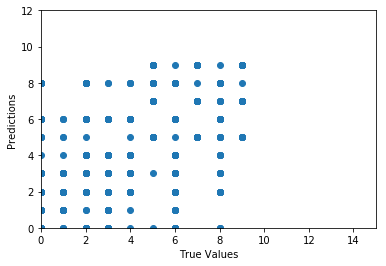

In [44]:
## The line / model
#%pylab inline
plt.scatter(classification_test, results)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis([0, 15, 0, 12])
plt.show()

In [45]:
comp= np.equal(list(classification_test.ravel()), list(results))
#print(comp.shape)
#print(classification_test.ravel())
#print(results)
print(comp)
print(comp.sum())
print('Percentage: {}'.format(100*(comp.sum()/(len(comp)))))

[ True  True  True ...,  True False False]
8445
Percentage: 84.45


In [147]:
answers = np.zeros((len(classification),10))
classification.ravel()[0:2]
for idx,row in enumerate(answers):
    row[int(classification.ravel()[idx])]=1
    
answers_test = np.zeros((len(classification_test),10))
classification_test.ravel()[0:2]
for idx,row in enumerate(answers_test):
    row[int(classification_test.ravel()[idx])]=1

[[ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]]


In [111]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1],padding='SAME')

In [112]:
def maxpool2d(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [116]:
def convolutional_neural_network(x):
    weights = {'W_conv1':tf.Variable(tf.random_normal([5,5,1,32])),
               'W_conv2':tf.Variable(tf.random_normal([5,5,32,64])),
               'W_fc':tf.Variable(tf.random_normal([7*7*64,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}
    
    x = tf.reshape(x, shape=[-1,28,28,1])

    conv1 =  tf.nn.relu( conv2d(x,weights['W_conv1']) + biases['b_conv1'] )
    conv1 =  maxpool2d(conv1)

    conv2 =  tf.nn.relu( conv2d(conv1,weights['W_conv2']) + biases['b_conv2'] )
    conv2 = maxpool2d(conv2)
    
    fc = tf.reshape(conv2,[-1,7*7*64])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    
    output = tf.matmul(fc, weights['out'])+biases['out']
    
    return output

In [155]:
def train_neural_network(x,y,n_classes,batch_size):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    hm_epochs = 2
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(hm_epochs):
            epoch_loss = 0
            for _ in range(int(len(classification.ravel())/batch_size)):
                epoch_x = preclassifier_data[batch_size*_:batch_size*(_+1)][0:784]
                epoch_y = answers[batch_size*_:batch_size*(_+1)]
                _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
                epoch_loss += c

            print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)

        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy: {}'.format(accuracy.eval({x: preclassifier_data_test, y: answers_test})))

In [ ]:
n_classes = len(definitions)
batch_size = 100
x = tf.placeholder('float', [None,784])
y = tf.placeholder('float')        
        
train_neural_network(x,y,n_classes,batch_size)

Epoch 0 completed out of 2 loss: 453610722.078
Epoch 1 completed out of 2 loss: 185203697.43
